In [2]:
import os
import re
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np

from konlpy.tag import Mecab
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer

from dotenv import load_dotenv

load_dotenv()
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

mecab = Mecab(os.environ['MECAB_DIC_PATH'])
stemmer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/jerry/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jerry/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [32]:
df = pd.read_csv('./data/link_data.csv').fillna('')



unique_pik = dict(set(zip(df.pik_id, df.pik_title)))
unique_category = dict(set(zip(df.category_id, df.category_title)))
unique_link = dict(set(zip(df.link_id, df.memo)))\

index_to_pik = {idx: row.pik_id for idx, row in df.iterrows()}

pik_to_index = {x: idx for idx, x in enumerate(list(unique_pik.keys()))}
category_to_index = {x: idx for idx, x in enumerate(list(unique_category.keys()))}
link_to_index = {x: idx for idx, x in enumerate(list(unique_link.keys()))}

In [4]:
pik_to_num = df.groupby(['pik_id'], as_index=False).count()
pik_to_num = {row[0]: row[1] for _, row in pik_to_num.iterrows()}

In [5]:
def preprocess(text: str):
    
    result = re.sub(pattern=r'[\[\]():|]', repl='', string=text)
    result = re.sub(pattern=r'\s', repl=' ', string=result)
    result = re.sub(pattern=r'[一-龥]', repl='', string=result)
    result = re.sub(pattern=r'[ㄱ-ㅎㅏ-ㅣ]', repl=' ', string=result)

    result.strip()
    result = ' '.join(result.split())

    return result

In [6]:
def extract_noun(text: str, target_pos=['NNG', 'NNP', 'NNB']) -> List[str]:

    def is_noun(word: Tuple[str, str]) -> bool:

        if word[1] in target_pos:
            return True
        elif word[1] == 'SL' and nltk.pos_tag([word[0]])[0][1] == 'NN':
            return True
        return False

    pos_list : List[Tuple[str, str]] = mecab.pos(preprocess(text))
    result = [stemmer.lemmatize(p[0]) for p in pos_list if is_noun(p)]

    return result

In [7]:
tfidf_vectorizer_pik = TfidfVectorizer(tokenizer=lambda x: extract_noun(x), min_df=2, max_features=500)
tfidf_vectorizer_category = TfidfVectorizer(tokenizer=lambda x: extract_noun(x), min_df=2, max_features=500)
tfidf_vectorizer_link = TfidfVectorizer(tokenizer=lambda x: extract_noun(x), min_df=2, max_features=500)
# count_vectorizer = CountVectorizer(tokenizer=lambda x: extract_noun(mecab, x), min_df=2, max_features=5000)

In [8]:
vec_pik = tfidf_vectorizer_pik.fit_transform(list(unique_pik.values()))
vec_category = tfidf_vectorizer_category.fit_transform(list(unique_category.values()))
vec_link = tfidf_vectorizer_link.fit_transform(list(unique_link.values()))

## K-Means Clustering

In [9]:
def concat_matrix(
    pik_matrix, category_matrix, link_matrix,
    pik_to_index, category_to_index, link_to_index
):
    pik_matrix_index = [pik_to_index[i] for i in df.pik_id]
    category_matrix_index = [category_to_index[i] for i in df.category_id]
    link_matrix_index = [link_to_index[i] for i in df.link_id]

    tmp_pik_vec = pik_matrix[pik_matrix_index]
    tmp_category_vec = category_matrix[category_matrix_index]
    tmp_link_vec = link_matrix[link_matrix_index]

    concat_matrix = np.concatenate((tmp_pik_vec, tmp_category_vec, tmp_link_vec), axis=1)

    return concat_matrix

In [10]:
concat_matrix = concat_matrix(vec_pik.toarray(), vec_category.toarray(), vec_link.toarray(), pik_to_index, category_to_index, link_to_index)
concat_matrix.shape

(50442, 1500)

In [11]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [12]:
Kmeans = KMeans(n_clusters=20)
Kmeans.fit(concat_matrix)

KMeans(n_clusters=20)

In [13]:
labels = Kmeans.predict(concat_matrix)

In [20]:
def extract_data_by_label(target_label: int, labels: List[int]) -> pd.DataFrame:
    target_ids = [idx for idx, label in enumerate(labels) if label == target_label]
    return df.loc[target_ids]

def extract_statics_by_label(target_label: int, labels: List[int]) -> Dict[int, int]:
    target_ids = [idx for idx, label in enumerate(labels) if label == target_label]
    target_df = df.loc[target_ids]
    grouped = target_df.groupby(['pik_id']).count()

    return {pik_id: row[0] for pik_id, row in grouped.iterrows()}

def convert_ratio(target_dict: Dict[int, int]) -> Dict[int, Dict[str, float]]:
    result = {pik_id: {'title': unique_pik[pik_id], 'ratio': num / pik_to_num[pik_id]} for pik_id, num in target_dict.items()}

    result
    return result

In [15]:
import random
from matplotlib import colors as mcolors


colors = mcolors.TABLEAU_COLORS
by_hsv = {name: mcolors.to_rgba(np.append(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3]), .4))
                for name, color in colors.items()}

color_names = list(by_hsv.keys())
random.shuffle(color_names)

## T-SNE

In [16]:
tsne = TSNE(random_state = 42)
# TSNE에는 transform 메서드가 없으므로 대신 fit_transform을 사용한다.
link_tsne = tsne.fit_transform(concat_matrix)

/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/jerry/anaconda3/envs/tokenizer/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.


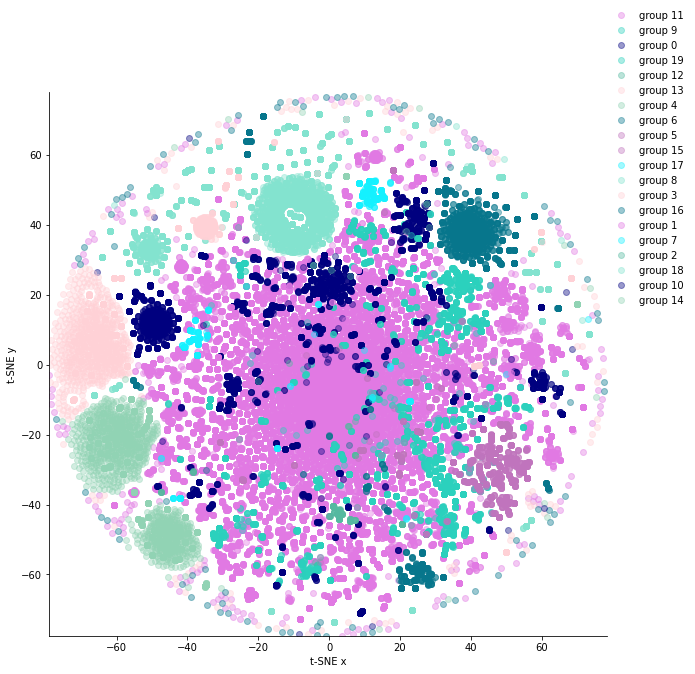

In [17]:
plt.figure(figsize=(10,10))
plt.xlim(link_tsne[:,0].min(), link_tsne[:,0].max()+1)
plt.ylim(link_tsne[:,1].min(), link_tsne[:,1].max()+1)

tsne_point_by_label = dict()

for i in range(len(concat_matrix)):
    label = labels[i]
    try:
        tsne_point_by_label[label]['x'].append(link_tsne[i, 0])
        tsne_point_by_label[label]['y'].append(link_tsne[i, 1])
    except KeyError:
        tmp_dict = {'x': [link_tsne[i, 0]], 'y': [link_tsne[i, 1]]}
        tsne_point_by_label[label] = tmp_dict


for label, coordinates in tsne_point_by_label.items():
    plt.plot(coordinates['x'], coordinates['y'], 'ro', color=by_hsv[color_names[label % 10]], label=f'group {label}')
    
plt.xlabel("t-SNE x")
plt.ylabel("t-SNE y")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc=(1.0, .6), frameon=False)

In [38]:
class KmeansModel:
    
    def __init__(self, model, labels, index_to_pik, pik_to_title, pik_to_num):
        self.model = model
        self.labels= labels
        self.index_to_pik = index_to_pik
        self.pik_to_title = pik_to_title
        self.pik_to_num = pik_to_num

    def predict(self, vectorized):
        result = self.model.predict(vectorized.reshape(1, -1))
        return result[0]
    
    def extract_statics_by_label(self, target_label, desc=True):
        from collections import Counter
        
        target_piks = [self.index_to_pik[idx] for idx, label in enumerate(self.labels) 
            if label == target_label]
        pik_freq = dict(Counter(target_piks))
        result = {pik_id: {'title': self.pik_to_title[pik_id], 'ratio': num / self.pik_to_num[pik_id]} for pik_id, num in pik_freq.items()}
        
        if desc:
            result = sorted(result.items(), key=lambda x: x[1].get('ratio'))
            result.reverse()

        return result
        
        


In [39]:
sample_model = KmeansModel(Kmeans, labels, index_to_pik, unique_pik, pik_to_num)

In [46]:
import pickle

with open('./models/sample.pkl', 'wb') as m:
    saved_model = pickle.dump(sample_model, m)

In [47]:
with open('./models/sample.pkl', 'rb') as m:
    loaded_model = pickle.load(m)

In [48]:
loaded_model.predict(concat_matrix[0])

11